# **3장 – 분류**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42) #통상적으로 42를 많이 쓴다~

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 3.1 MNIST

### MNIST란? 손으로 쓴 숫자들로 이뤄진 대형 데이터셋, 학습용으로 아주 많이 사용.

다음은 MNIST를 내려받는 코드이다
<br>사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고있다.
* 데이터 셋을 설명하는 DESCR 키
+ 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
+ 레이블 배열을 담은 target 키

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

배열들을 살펴본다.

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

이미지(샘플)가 70000개 있고, 각 이미지에는 784개의 특성이 있다.
<br> 784 = 28 * 28 이고 이는 이미지가 28 * 28 픽셀이기 때문이다.

[Numpy array를 shape로 차원확인 하기](https://barambunda.tistory.com/11)

샘플의 특성 벡터를 추출해서 28x28 배열로 크기를 바꾸고 matplotlib의 imshow() 함수를 사용해 그린다.

그림 저장: some_digit_plot


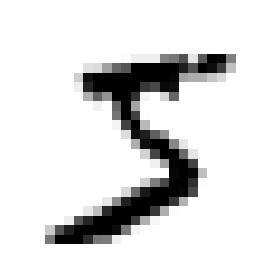

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) #28*28 배열로 다시 크기 바꾸기
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
y[0]

'5'

5같아서 보니까 5가 맞다.

In [7]:
y = y.astype(np.uint8) # y를 정수로 변환

레이블은 문자열이다. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환한다.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

데이터를 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 한다.
<BR>사실 MNIST 데이터셋은 훈련 세트(앞 60000개 이미지)와 테스트 세트(뒤 10000개 이미지)로 나누어져있다.

# 3.2 이진 분류기 훈련

문제를 단순화해서 하나의 숫자(5)만 식별해본다. 분류 작업을 위한 타깃 벡터를 만든다.

In [9]:
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

[SGD(확률적 경사 하강법)](https://velog.io/@arittung/DeepLearningStudyDay8)분류기를 사용한다.
+ 매우 큰 데이터 셋을 효율적으로 처리
+ 한 번에 하나씩 훈련 샘플을 독립적으로 처리

**노트**: `max_iter`와 `tol` 같은 일부 매개변수는 사이킷런 다음 버전에서 기본값이 바뀝니다. 버전이 업데이트되더라도 결과가 바뀌지 않도록 아예 나중에 바뀔 기본값을 사용해 명시적으로 지정하겠습니다. 번거로움을 피하기 위해 책에는 따로 표시하지 않았습니다.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측했다.(True) 성공!

# 3.3 성능 측정

## 3.3.1 교차 검증을 사용한 정확도 측정

직접 교차 검증 구현해보자.
<br>다음 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력한다.

In [12]:
# 교차 검증 구현(사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 때)

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

훈련세트 3개 폴드의 교차 검증이고, 모든 교차 검증 폴드에 대헤 정확도가 95% 이상이다.

모든 이미지를 5 아님 클래스로 분류하는 더미 분류기를 만들어서 비교해본다.

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90% 이상, 이미지의 10% 정도만 숫자 5이기 떄문에 무조건 5아님으로 예측하면 정확히 맞출 확률이 90%

★ 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유(특히 불균형한 데이터 셋을 다룰때. 즉 어떤 클래스가 다른 것보다 월등히 많은 경우)

지금 같은 경우는 5가 아님이 월등히 많은 케이스

노트: 이 출력(그리고 이 노트북과 다른 노트북의 출력)이 책의 내용과 조금 다를 수 있습니다. 걱정할 필요 없습니다. 괜찮습니다! 달라지는 이유가 몇가지 있습니다:

* 첫째, 사이킷런과 다른 라이브러리들이 발전하면서 알고리즘이 조금씩 변경되기 때문에 얻어지는 결괏값이 바뀔 수 있습니다. 최신 사이킷런 버전을 사용한다면(일반적으로 권장됩니다) 책이나 이 노트북을 만들 때 사용한 버전과 다를 것이므로 차이가 납니다. 노트북은 최신으로 업데이트하려고 노력하지만 책의 내용은 그렇게 할 수 없습니다.
* 둘째, 많은 훈련 알고리즘은 확률적입니다. 즉 무작위성에 의존합니다. 이론적으로 의사 난수를 생성하도록 난순 생성기에 시드 값을 지정하여 일관된 결과를 얻을 수 있습니다(random_state=42나 np.random.seed(42)를 종종 보게 되는 이유입니다). 하지만 여기에서 언급한 다른 요인으로 인해 충분하지 않을 때가 있습니다.
* 세째, 훈련 알고리즘이 여러 스레드(C로 구현된 알고리즘)나 여러 프로세스(예를 들어 n_jobs 매개변수를 사용할 때)로 실행되면 연산이 실행되는 정확한 순서가 항상 보장되지 않습니다. 따라서 결괏값이 조금 다를 수 있습니다.
* 마지막으로, 여러 세션에 결쳐 순서가 보장되지 않는 파이썬 딕셔너리(dict)이나 셋(set) 같은 것은 완벽한 재현성이 불가능합니다. 또한 디렉토리 안에 있는 파일의 순서도 보장되지 않습니다.

## 3.3.2 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것.
<br> 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것.
<BR>예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.

즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다. (깨끗하다 = 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다.)

confusion_matrix() 함수를 사용해 오차 행렬을 만든다. 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출한다.

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### 잠깐! 여기서 오차 행렬을 복습해보자.

 ![오차행렬](img/오차행렬.png)

###### 오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.
<BR>이 행렬의 첫 번쨰 행은 5아님 이미지(음성 클래스)에 대한 것으로 53892개를 5아님으로 정확히 분류 (TN)
<BR>나머지 687개는 5라고 잘못 분류 (FP)
<BR>두 번쨰 행은 5이미지(양성 클래스)에 대한 것으로 1891개를 5아님으로 잘못 분류(FN)
<BR>나머지 3530개를 정확히 5라고 분류(TP)    

In [18]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

이 경우 진짜 양성과 진짜 음성만 가지고 있으므로 오차 행렬의 주대각선(왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 된다.

## 3.3.3 정밀도와 재현율

## 정밀도(Precision)와 재현율(Recall)의 공식

## 정밀도 = $TP\over TP+FP$       재현율 = $TP\over TP+FN$

precision_socre() = 정밀도 계산 함수, recall_score() = 재현율 계산 함수

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

정확도에서 봤을 때보다 수치가 많이 떨어진 것을 알 수 있다. 
<BR>5로 판별된 이미지 중 83.7%만 정확하고, 전체 숫자 중에서 65.1%만 감지했다.

## F1 점수 공식

## F1 점수는 정밀도와 재현율의 조화평균이고 식을 유도하면 $TP\over{TP+{FN+FP\over2}}$

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## 3.3.4 정밀도/재현율 트레이드오프

SGDClassifiesr의 분류 결정 방법 : 이 분류기는 결정 함수(decision function)를 사용하여 각 샘플의 점수를 계산.
<br>점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다

### 결정 임곗값에 대한 보충 설명
 ![decision](img/decision.jpg)

사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능.
<br> 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있고, 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

SGDClassifier의 임곗값이 0이므로 위 코드는 predict() 메서드와 같은 결과(True)를 반환한다.
<br> *사실 predict() 메서드도 decision_function() 함수를 사용하여 0보다 큰 경우를 양성으로 예측한다.

In [27]:
y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임곗값을 높이면 재현율이 줄어든다는 것을 보여준다.
이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8000으로 높이면 이를 놓치게 된다.

따라서 적절한 임곗값을 찾으려면 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
<br>하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 한다.

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


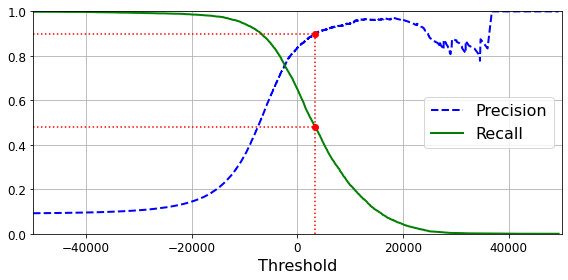

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    
    
    
    
   # 이하 내용은 그래프 설정
    plt.legend(loc="center right", fontsize=16) # Not shown
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

정밀도와 재현율의 트레이드오프 관계를 알 수 있다.
<br> 임곗값을 올리면 재현율은 무조건 줄어들지만, 정밀도는 보통은 늘어나는 경향을 띄지만, 줄어들 때도 있기 떄문에 울퉁불퉁한 모양을 보여준다.

그림 저장: precision_vs_recall_plot


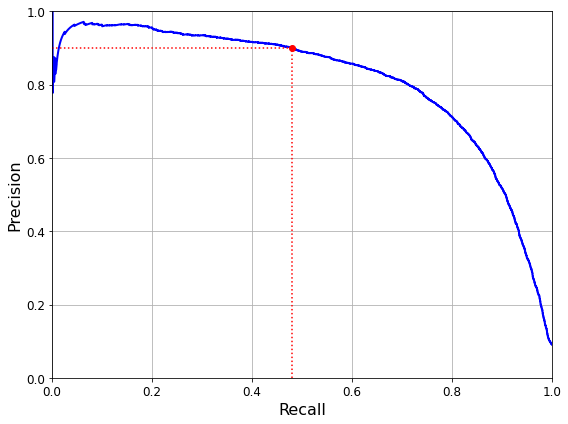

In [33]:
# 정밀도/재현율 트레이드오프를 선택하기 위해 재현율에 대한 정밀도 곡선을 그리는 것.

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

책에 따르면 하강점 직전(정밀도 60% 재현율 80% 지점)을 트레이드오프로 선택하는 것이 좋다고 한다.

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있다.

In [35]:
threshold_90_precision

3370.0194991439557

이 지점 채택시의 임곗값

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

이 지점 채택시의 정밀도와 재현율이다. 누군가 99% 정밀도를 달성하자라고 말하면 재현율은 얼마에서라고 물어보자.

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC 곡선

### ROC(수신기 조작 특성) = 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)
#### 양성으로 잘못 분류된 음성 샘플의 비율이 FPR, 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR)을 뺀 값.
#### TNR을 특이도라고도 한다. 그러므로 ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프이다.

### 잠깐! 헷갈리는 용어 정리해보고 넘어가자.
#### 정밀도 = precision
#### 재현율 = recall = 민감도(sensitivity) = 진짜 양성 비율(TPR)
#### 진짜 음성 비율(TNR) = 특이도(specificity)

#### $FPR$ = $ FP\over {FP+TN}  $ = $1-TNR$

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


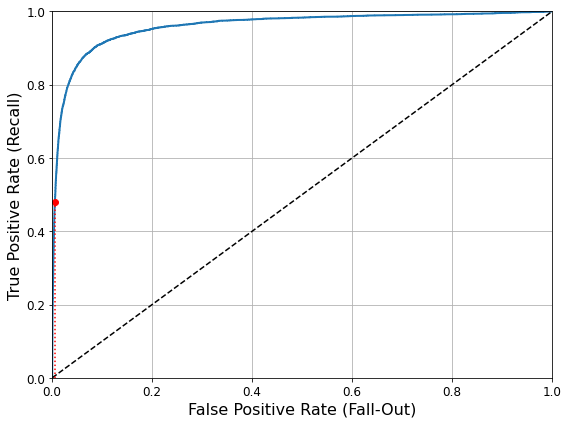

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown 
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

붉은 점이 선택한 비율의 지점(43.68%의 재현율)

곡선 아래의 면적을 AUC라 하는데, 이를 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

완전한 랜덤 분류기는 FPR과 TPR값이 비슷해져서 y=x가 되기 때문이다.

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## ROC VS PR(정밀도/재현율)
<BR> ROC곡선과 PR곡선이 비슷한데, 보통 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 떄 PR 곡선을 사용하고 
    <BR>그렇지 않으면 ROC 곡선을 사용한다.

**노트**: 사이킷런 0.22 버전에서 바뀔 기본 값을 사용해 `n_estimators=100`로 지정합니다.

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해본다.
<BR>먼저 훈련 세트의 샘플에 대한 점수를 얻는데, 작동 방식의 차이에 의해 RandomForestClassifier에는 decision_function() 메서드가 없다.
<br>대신 predict_proba() 메서드가 있다. predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.

In [42]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [43]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용한다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


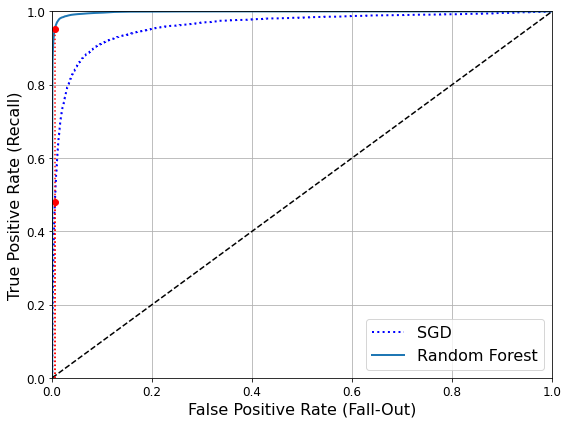

In [44]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

ROC가 99.8%, 정밀도와 재현율이 각각 99%, 86.6%가 나온다.

In [46]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 3.4 다중 분류

## 이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기는 둘 이상의 클래스를 구별할 수 있다.
### SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등은 여러 개의 클래스를 직접 처리할 수 있는 반면
### 로지스틱 회귀나 서포트 벡터 머신 분류기 같은 다른 알고리즘은 이진 분류만 가능하다.
### 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많다.

예를 들어 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다.
<BR>이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하는 것. 이를 QvR 전략 혹은 QvA 전략이라고 부른다.
<BR>또 다른 전략은 0과 1구별 0과 2구별 1과 2구별 같이 각 숫자의 조합마다 이진분류기를 훈련시키는 것이다. 이를 OvO 전략이라고 한다.
<br>각각 선호되는 알고리즘이 달라 구별해서 사용한다.

sklearn.svm.SVC 클래스를 사용해 서포트 벡터 머신 분류기를 테스트 해보자.

In [48]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
# y_train_5이 아니라 y_train 사용(5를 구별한 타킷 클래스 말고 0부터 9까지의 원래 타킷 클래스)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

내부에서는 사이킷런이 OvO 전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다.

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

실제로 샘플당 10개의 점수를 반환하는 것을 알 수 있다.

In [50]:
np.argmax(some_digit_scores)

5

가장 높은 점수가 클래스 5에 해당하는 값이다.

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
svm_clf.classes_[5]

5

위 예제에서는 인덱스 5에 해당하는 클래스의 값은 5로 똑같지만 이는 우연! 일반적으로 이런 경우는 드물다.

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClasiifier나 OneVsRestClassifier를 사용한다.
<br> 다음 코드는 SVC 기반으로 OvR 전략을 사용하는 다중 분류기를 만든다.

In [53]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

10

SGDClassifier를 훈련시키는 것도 간단하다.
<br> SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없다.

In [66]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [56]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

이 결과에서 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있다. 대부분의 점수가 큰 음수이기 때문이다.
<BR> 이 모델은 -1385점을 받은 클래스 6을 의심하고 있다.

**경고**: 사용하는 하드웨어에 따라 다음 두 셀을 실행하는데 30분 또는 그 이상 걸릴 수 있습니다.

coss_val_score() 함수를 사용해 SGDClassifier의 정확도를 평가해본다.

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 84% 이상을 얻었으므로 좋다.

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

이렇게 입력의 스케일을 조정하면 정확도를 89% 이상으로 높일 수 있다.

# 3.5 에러 분석

오차 행렬을 살펴본다. cross_val_predict()함수를 사용해 예측을 만들고 이전처럼 confusion_matrix() 함수를 호출한다.

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

사이킷런 0.22 버전부터는 `sklearn.metrics.plot_confusion_matrix()` 함수를 사용할 수 있습니다.

숫자가 많으므로 오차 행렬을 matshow() 함수를 사용해 이미지로 표현하면 보기에 편리하다.
<BR>배열에서 가장 큰 값은 흰색으로, 가장 작은 값은 검은색으로 정규화되어 그려진다.

그림 저장: confusion_matrix_plot


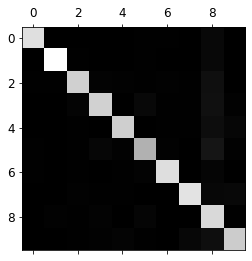

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주 대각선에 있으므로 매우 좋아 보인다. 하지만 숫자 5는 좀 어두워 보인다.
<BR> 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다. 원래는 두 경우에 대해 모두 확인해봐야 된다.
<BR> 하지만 그래프의 에러 부분에 초점을 맞춰보자.

+ MNIST는 클래스별 이미지 개수가 동일하지 않기 때문이다.

먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다.
<BR> 즉, 절대적인 에러의 개수를 비교하는 것이 아니다. 개수로 비교하면 이미자가 많은 클래스가 상대적으로 나쁘게 보인다.

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

다른 항목은 그대로 유지하고 주 대각선만 0으로 채워서 그래프를 그린다. (주 대각선은 필요가 없으므로)

그림 저장: confusion_matrix_errors_plot


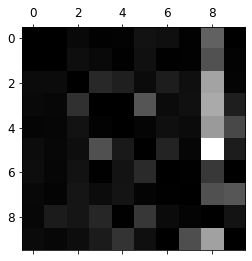

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

여기서 분류기가 만든 에러를 확실히 볼 수 있다. 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.
<BR> 클래스의 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다.
<BR> 하지만 클래스 8의 행은 그리 나쁘지 않다. 이는 실제 8이 적절히 8로 분류되었다는 것을 말해준다.
<BR> 3과 5가 서로 많이 혼동되고 있다는 것도 알 수 있다.

그림 저장: error_analysis_digits_plot


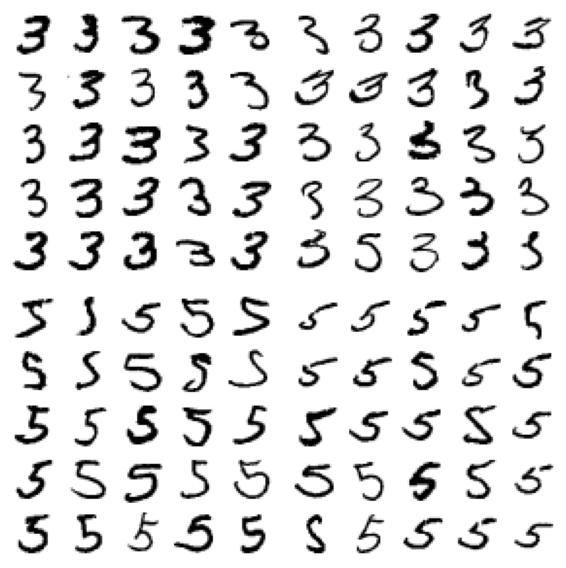

In [69]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

왼쪽의 5x5 불록 두 개는 3으로 분류된 이미지이고 오른쪽 5x5 블록 두 개는 5로 분류된 이미지이다.
<br> 이해가 안되는 오류는 픽셀의 차이가 적기 때문이다. (p151쪽 참고)

# 3.6 다중 레이블 분류

## 여러 개의 이진 꼬리표를 출력하는 분류 시스템이다.
### 예를 들어 분류기가 앨리스, 밥, 찰리의 얼굴을 인식한다고 하고, 앨리스와 찰리가 있다면 [1, 0, 1]을 출력

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다.
<br>첫 번째는 숫자가 큰 값(7, 8, 9)인지 나타내고 두 번째는 홀수인지 나타낸다. 
<br>그 다음 줄이 KNeighborClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킨다.

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

올바르게 분류되었다! 숫자 5는 크지 않고(False), 홀수(True)이다. 

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

다중 레이블 분류기를 평가하는 방법은 많다. 적절한 지표는 프로젝트에 따라 다르다. 
<BR>다음 코드는 모든 레이블에 대한 F1 점수의 평균을 계산한다.

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 3.7 다중 출력 분류

## 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것
## (즉, 값을 두 개 이상 가질 수 있다.)

이미지에서 잡음을 제거하는 시스템을 만든다. 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다. 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러개 가진다.(0부터 255까지 픽셀 강도)

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint()함수를 사용하여 픽셀 강도에 잡음을 추가한다. 
<br>타깃 이미지는 원본 이미지가 된다. 

그림 저장: noisy_digit_example_plot


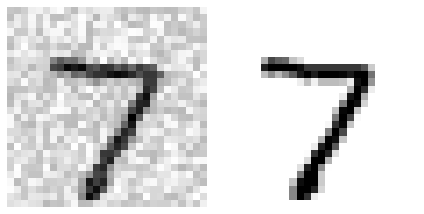

In [88]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

테스트 세트에서 이미지를 하나 선택한다. 왼쪽이 잡음이 섞인 입력 이미지이고 오른쪽이 깨끗한 타깃 이미지다. 
<br>분류기를 훈련시켜 이 이미지를 깨끗하게 만들어본다.

그림 저장: cleaned_digit_example_plot


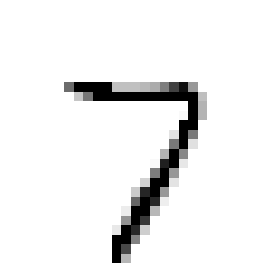

In [89]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")